### INSH 6404 - Analyzing complex digital data

# Final project - Official government-sponsored flows of money into Serbia (case of government debt)

### Milan Skobic

# Introduction

## Reason and questions

How can we assess the relation between state governments, patterns of capital accumulation, and class conflict and formation in a (semi-)peripheral context?

One entry point is the issue of legitimacy of state policies - how does a certain government construct itself as legitimate? In the case of Serbia, which we will explore here, government often relies on economic indicators promoted by transnational financial institutions such as the IMF and World Bank, including GDP growth, average salary, and others, to present itself as successful and therefore legitimate.

One among those indicators, is ratio of government debt to GDP. For (semi-)peripheral (or "developing") countries, transnational institutions advocate government debt not to exceed more than 50% of GDP. That is also something which Serbian government adheres to, and which the political elite boasts about. 

However, while the government uses this to substantiate its self-promotion, it is not clear how we can interpret the social meaning of this indicator. What are the side effects and particular relations that constitute these "successes"?

If we are able to ask and answer questions in this direction, we can generate insights of both theoretical and practical relevance. Theoretically, debates about the possible changing organization of global capitalism are prominent in recent years, and there have been indications that various peripheral contexts can  present harbingers of trends that are to emerge on a global level. Issues of power relations and scales, class formation and conflict, debt and value are all at stake.
Practically, speaking truth to power and generating a granulated picture of its actions allows for more incisive political interventions and specification of alternative policies.

In order to start answering these questions, we turn to yearly budgets of Serbian government, and more specifically, who it borrows the money from. We will parse several tables with a code developed for that purpose, and in that way chart the changing actors and their prominence among the lenders to Serbian government. Answering this question and generating a dataset about it will, in turn, generate many more specific practical, empirical, and theoretical questions. In this way, we will demonstrate one of the main merits of this approach, showing how it encourages and supports imagination which can detect new patterns and ask new questions. 

# Coding and preparing data

In [1]:
#relevant packages for generating the dataset

import pandas as pd
import numpy as np
from tabula import read_pdf
from tabula import convert_into

We will parse one document at the time, because of constantly shifting ways the document is organized. As we go through documents a general dataset will emerge, containing the names of the actors and the amount of money borrowed from them per year.

In [2]:
df1=read_pdf("budzeti srbije/budzet 2019lat.pdf", pages='5-7', multiple_tables=True, spreadsheet=True, encoding='Windows 1250')
r_n_l=['I.','II.','III.','IV.','V.','VI.','VII.','VIII.','IX.','X.','XI.','XII.','XIII.','UKUPNO']

conversion_ratesEURUSD={"2018":1.18, "2017":1.13, "2016":1.11, "2015":1.11, "2014":1.33, "2013":1.33, "2012":1.28, "2011":1.39, "2010":1.13, "2009":1.39, "2008":1.47, "2007":1.37, "2006":1.26, "2005":1.24, "2004":1.24, "2003":1.13, "2002":0.95}
#source for conversion rates https://www.statista.com/statistics/412794/euro-to-u-s-dollar-annual-average-exchange-rate/

conversion_ratesCNYUSD={"2018":1/6.62,"2017":1/7.03,"2016":1/6.91,"2015":1/6.489,"2014":1/6.394,"2013":1/6.446}
#source for CNY to USD conversion rates https://www.irs.gov/individuals/international-taxpayers/yearly-average-currency-exchange-rates/

year=2019

In [3]:
del df1[4] ##part of the new table at the last pdf page containing the relevant table.
del df1[0] ##part of the previous table at the same page.

Functions - these are the functions that have been developed mostly out of for loops created during the parsing of documents. Most of them have been developed based on the "budzet" (budget) file for 2019. This means some aspects of the parsing the files for the following years have remained hard coded because different tables present in "budzet" files for different years were formatted by the authors in different way.

In [4]:
#since pdf parser returns the table broken into several parts because of multiple pages on which it is located
#i make a function for merging those parts
def merge_dataframes(df1):
    df=pd.DataFrame()
    for ldf in df1:
        df=df.append(ldf)
    return(df)

#function for getting row index numbers, from 0 to length of the table
def reset_index(merg_df1):
    merg_df1.index = np.arange(0, len(merg_df1))
    return(merg_df1)

#creating the new column - number - which serves to prepare the separation of the dataframe according to actors
#subsection of the table for each actors starts with a roman numeral - we will add that numeral to each row of the subsection
def numeral_column(merg_df1):
    merg_df1["number"]=''
    c=0
    a=0
    for row in merg_df1.itertuples():
        merg_df1["number"].iloc[c]=''
        row=[str(item) for item in merg_df1.iloc[c]]
        for x in row:
            for item in r_n_l:
                if item==x:
                    merg_df1["number"].iloc[c]=item
                    a=item
                    continue
                else:
                    merg_df1["number"].iloc[c]=a
                    continue
        c+=1
    return(merg_df1)

#make a loop that counts how many different currencies there are in the column no3 where currencies are shown
#then cut as many last rows as there are currencies
#this removes the rows with the total sum of the money for all actors, which is not of particular interest to us
def erase_rows(merg_df1):
    curr_list=[]
    for item in merg_df1[3]:
        if item not in curr_list:
            curr_list.append(item)
        else:
            continue
    curr_list=[str(item) for item in curr_list]
    curr_list.remove('nan')
    a=int(len(curr_list))
    merg_df1=merg_df1.iloc[:-a]
    return(merg_df1)

#cleaning the value from a tuple into a DataFrame
#and removing the number column which does not have a point anymore
def clean_df(d):
    for key,value in d.items():
        df_tuple=value
        numeral,df=df_tuple
        df=df.drop(["number"], axis=1)
        df=reset_index(df)
        d[key]=df
    return(d)

#function to prepare tuples- the result should be a string Currency, and integer number
def tup_prep(tup):
    num,curr=tup
    num=str(num)
    num=num.replace('.','')
    num=int(num)
    tup=(num,curr)
    return(tup)

def get_tups(df):
    for row in df.itertuples():
        ukupno1_tuple=(row[5],row[4])
        for x in row:
            x=str(x)
            if "Ukupno" in x:
                ukupno2_tuple=(row[5], row[4])#even though columns start with 0, index for tuple starts with one (in dataframe the column is 4, but here i have to put 5 )
                curr=row[4]
    ukupno1_tuple=tup_prep(ukupno1_tuple)
    ukupno2_tuple=tup_prep(ukupno2_tuple)
    return(ukupno1_tuple,ukupno2_tuple)

#currency conversion function EUR to USD
def conv_to_dolEU (some_tuple, year):
    num,curr=some_tuple
    key=year-1
    key=str(key)
    if curr=="EUR":
        numb=num*conversion_ratesEURUSD[key]
        curr="USD"
        new_tuple=numb,curr
        return(new_tuple)
    
#currency conversion CNY to USD
def conv_to_dolCNY (some_tuple, year):
    num,curr=some_tuple
    key=year-1
    key=str(key)
    if curr=="CNY":
        numb=num*conversion_ratesCNYUSD[key]
        curr="USD"
        new_tuple=numb,curr
        return(new_tuple)
    
#function for getting the variables with money and currency from the tuples
#function to return the total money, or combine two tuples to get total money in dollars
def get_mon_cur(ukupno1_tuple,ukupno2_tuple,year):
    if ukupno1_tuple==ukupno2_tuple:
        money,curr=ukupno1_tuple
        if curr=="EUR":
            total_tuple=conv_to_dolEU(ukupno1_tuple,year)
        elif curr=="CNY":
            total_tuple=conv_to_dolCNY(ukupno1_tuple,year)
        else:
            total_tuple=(money,curr)
        return(total_tuple)
    elif ukupno1_tuple!=ukupno2_tuple:
        mon1,cur1=ukupno1_tuple
        mon2,cur2=ukupno2_tuple
        if cur1=="EUR":
            new_tuple=conv_to_dolEU(ukupno1_tuple,year)
            num,curr=new_tuple
            mon2,cur2=ukupno2_tuple
            mon=num+mon2
            cur=curr
            total_tuple=(mon,cur)
        elif cur2=="EUR":
            new_tuple=conv_to_dolEU(ukupno2_tuple,year)
            num,curr=new_tuple
            mon1,cur1=ukupno1_tuple
            mon=num+mon1
            cur=curr
            total_tuple=(mon,cur)
        elif cur1=="CNY":
            new_tuple=conv_to_dolCNY(ukupno1_tuple,year)
            num,curr=new_tuple
            mon2,cur2=ukupno2_tuple
            mon=num+mon2
            cur=curr
            total_tuple=(mon,cur)
        elif cur2=="CNY":
            new_tuple=conv_to_dolCNY(ukupno2_tuple,year)
            num,curr=new_tuple
            mon1,cur1=ukupno1_tuple
            mon=num+mon1
            cur=curr
            total_tuple=(mon,cur)
        return(total_tuple)
    


Processing the first table - using the defined functions, as well as the functions which are parts of the used packages, or python in general.

In [5]:
merg_df1=(merge_dataframes(df1))
merg_df1=reset_index(merg_df1)
merg_df1=numeral_column(merg_df1)
merg_df1=merg_df1.drop([0], axis=0) #erasing the first row, which does not contain info on any of the lenders
merg_df1=erase_rows(merg_df1)

#creating a dictionary out of the dataframe
#the idea is that each value is a subdataframe, dedicated to an individual actor
merg_grouped=merg_df1.groupby('number')
d={}
c=1
for frame in merg_grouped:
    d["2019-%s"%(c)]=frame#note hard coded year
    c+=1
    
#for loop for getting actor names
act_name_list=[]
d=clean_df(d)
for value in d.values():
    act_name=str(value.at[0,1])
    act_name_list.append(act_name)
    
#translation of the actor names is an issue
#we will use the list with abreviations, and bellow is the list with full names of "actors"
#long names require two lists, one "ab" (abbreviations), and one with full names, useful as labels in visulaziations
act_name_list_eng_ab=["WB", "EIB", "EBRD", "CEB", "Imp-exp banks", "KfW", "For-gov", "Inst-invest", "For-invest CFB", "China banks"]
act_name_list_eng=["World Bank", "European Investment Bank", "European Bank for Reconstruction and Development", "Council of Europe Development Bank", "Import-export banks", "German Development Bank", "Foreign Governments", "Institutional investors", "Foreign investment corporations, funds and banks", "Chinese banks"]

#making a dictionary with state/actor as a key, and money in dollars as a value
year_dict_ab={}
year=2019
#toward function for creating a dictionary for year
for value in d.values():
    act_name=str(value.at[0,1])#note hard coding
    ind=act_name_list.index(act_name)
    act_name=act_name_list_eng_ab[ind]
    a,b=get_tups(value)
    money,curr=get_mon_cur(a,b,year)
    year_dict_ab[act_name]=money

#the emerging combined dataframe
#dataframe with years as columns, actors as rows, and money in dollars as values
final_df=pd.DataFrame()
final_df["actors"]=year_dict_ab.keys()
final_df["2019"]=year_dict_ab.values()
final_df.set_index(["actors"], inplace=True)

#lets see how it looks for now - all the amounts are in USD
final_df

,2019
actors,
WB,4.694380e+08
EIB,6.926600e+08
EBRD,1.121000e+08
CEB,1.102120e+09
Imp-exp banks,7.080000e+07
KfW,8.496000e+07
For-gov,1.327500e+09
Inst-invest,2.006000e+09
For-invest CFB,9.440000e+08


Now the second table will be processed. We could call this a semi-automatized processing, with some things having to be hard coded because of the not-fully-standardized format of the tables with which we work.

In [6]:
df1=read_pdf("budzeti srbije/budzet 2018.pdf", pages='10-13', multiple_tables=True, spreadsheet=True, encoding='Windows 1250')
year=2018
#note the hard coded number of pages. Solution to this problem would require identifying patterns with which this table starts
#and ends across the files. Then a pdf reader package would be imported and a command would be developed to cut the existing 
#file and return a pdf document which consists only of the relevant table.

del df1[5] #part of the new table at the last pdf page containing the relevant table.
del df1[0] #part of the previous table at the same page.

merg_df1=(merge_dataframes(df1))
merg_df1=reset_index(merg_df1)
merg_df1=numeral_column(merg_df1)
merg_df1=merg_df1.drop([0], axis=0)
merg_df1=erase_rows(merg_df1)
merg_grouped=merg_df1.groupby('number')

d={}
c=1
for frame in merg_grouped:
    d["2018-%s"%(c)]=frame
    c+=1

update_list=[]
d=clean_df(d)
for value in d.values():
    act_name=str(value.at[0,1])
    update_list.append(act_name)
#print(update_list)
"""
['Svetskom bankom', 'Evropskom investicionom bankom', 'Evropskom bankom za obnovu i razvoj',
'Bankom za razvoj Saveta Evrope', 'Nemačkom razvojnom bankom (KfW)', 'Stranim vladama',
'Institucionalnim investitorima', 'Kineskom Export-Import bankom']
"""
#translation
act_name_list_eng_ab=["WB", "EIB", "EBRD", "CEB", "KfW", "For-gov", "Inst-invest", "China banks"]
act_name_list_eng=["World Bank", "European Investment Bank", "European Bank for Reconstruction and Development", "Council of Europe Development Bank", "German Development Bank", "Foreign Governments", "Institutional investors", "Chinese banks"]

year_dict_ab={}#ab stands for abbreviation
#toward function for creating a dictionary for year
for value in d.values():
    act_name=str(value.at[0,1])
    ind=update_list.index(act_name)
    act_name=act_name_list_eng_ab[ind]
    a,b=get_tups(value)
    money,curr=get_mon_cur(a,b,year)
    year_dict_ab[act_name]=money
#print(year_dict_ab)

#IMPORTANT! The number for world bank is not correct, because unlike in the rest of the table, they put
#the word "ukupno" in the last row, rather in the first row in which the total for a particular Currency
#is calculated. At this point I will hard code the correct result
year_dict_ab["WB"]=year_dict_ab["WB"]+350000000

In [7]:
#lets create the dataframe for this year, which we will then join to the emerging final dataframe (which serves for visualizations)
newdf=pd.DataFrame()
newdf["actors"]=year_dict_ab.keys()
newdf["2018"]=year_dict_ab.values()
newdf.set_index(["actors"], inplace=True)

final_df=final_df.merge(newdf, how='left', left_index=True, right_index=True)
final_df

,2019,2018
actors,,
WB,4.694380e+08,5.659430e+08
EIB,6.926600e+08,8.260300e+08
EBRD,1.121000e+08,1.130000e+08
CEB,1.102120e+09,5.085000e+07
Imp-exp banks,7.080000e+07,NaN
KfW,8.496000e+07,6.780000e+07
For-gov,1.327500e+09,1.600000e+07
Inst-invest,2.006000e+09,1.130000e+09
For-invest CFB,9.440000e+08,NaN


One more table - for 2017

In [8]:
df1=read_pdf("budzeti srbije/budzet 2017.pdf", pages='7-9', multiple_tables=True, spreadsheet=True, encoding='Windows 1250')
year=2017
del df1[4] #new table no connection whatsoever
del df1[0] #garancije - to su troškovi ne prilivi

merg_df1=(merge_dataframes(df1))
merg_df1=reset_index(merg_df1)
merg_df1=numeral_column(merg_df1)
merg_df1=merg_df1.drop([0], axis=0)
#in the last row they have put both currencies, rendering my erase_rows function inadequate
#world bank has been the only lender in two currencies, and they have put them in the same row
#we shall see later what happens
#merg_df1=erase_rows(merg_df1)
merg_df1=merg_df1.drop([36], axis=0)
merg_grouped=merg_df1.groupby('number')

d={}
c=1
for frame in merg_grouped:
    d["2017-%s"%(c)]=frame#note hard coding of the year number
    c+=1
#print(merg_df1)

update_list=[]
d=clean_df(d)
for value in d.values():
    act_name=str(value.at[0,1])
    update_list.append(act_name)

#info on what needs translation
update_list

['Svetskom bankom',
 'Evropskom investicionom bankom',
 'Bankom za razvoj Saveta Evrope',
 'Nemačkom razvojnom bankom (KfW)',
 'Stranim vladama',
 'Institucionalnim investitorima',
 'Kineskom Export - Import bankom']

In [9]:
#for value in d.values():
#    act_name=str(value.at[0,1])
#    ind=update_list.index(act_name)
#    act_name=act_name_list_eng_ab[ind]
#    a,b=get_tups(value)
#    money,curr=get_mon_cur(a,b,year)
#    year_dict_ab[act_name]=money
#print(year_dict_ab)

The above lines of code, a standard part of parsing a table, return a mistake, which comes from the row in the case of World Bank in which a single cell contains two currencies, and two numbers, respectively.
We know that because in the row in question table there are 390 000 000 USD and 407 000 000 Eur
and the error returns that the problem lies with ValueError: invalid literal for int() with base 10: '390000000\r407400000'


In [10]:
#copy of "update list" which will be useful in preparing the following table for the final dataframe
#['Svetskom bankom', 'Evropskom investicionom bankom', 'Bankom za razvoj Saveta Evrope',
#'Nemačkom razvojnom bankom (KfW)', 'Stranim vladama', 'Institucionalnim investitorima',
#'Kineskom Export - Import bankom']


#hard coded removal of the non-standardized row
act_name_list_eng_ab=["WB", "EIB", "CEB", "KfW", "For-gov", "Inst-invest", "China banks"]
del d['2017-1']
act_name_list_eng_ab=["EIB", "CEB", "KfW", "For-gov", "Inst-invest", "China banks"]
update_list.remove('Svetskom bankom')


In [11]:
#continue with by now standardized processing of the dataframes
year_dict_ab={}
for value in d.values():
    act_name=str(value.at[0,1])
    ind=update_list.index(act_name)
    act_name=act_name_list_eng_ab[ind]
    a,b=get_tups(value)
    money,curr=get_mon_cur(a,b,year)
    year_dict_ab[act_name]=money

#accounting for the problematic row of the World Bank in this table - combining Euros and Dollars   
dol=407000000*1.11
year_dict_ab['WB']=390000000+dol

In [12]:
newdf=pd.DataFrame()
newdf["actors"]=year_dict_ab.keys()
newdf["2017"]=year_dict_ab.values()
newdf.set_index(["actors"], inplace=True)

final_df=final_df.merge(newdf, how='left', left_index=True, right_index=True)
#and let's reverse the order of the columns for the purposes of visualization
columns = final_df.columns.tolist()
columns = columns[::-1]
final_df=final_df[columns]
final_df

,2017,2018,2019
actors,,,
WB,8.417700e+08,5.659430e+08,4.694380e+08
EIB,3.470970e+08,8.260300e+08,6.926600e+08
EBRD,NaN,1.130000e+08,1.121000e+08
CEB,4.995000e+07,5.085000e+07,1.102120e+09
Imp-exp banks,NaN,NaN,7.080000e+07
KfW,4.107000e+07,6.780000e+07,8.496000e+07
For-gov,1.600000e+07,1.600000e+07,1.327500e+09
Inst-invest,1.110000e+09,1.130000e+09,2.006000e+09
For-invest CFB,NaN,NaN,9.440000e+08


Here we stop with processing tables.

Context: Serbia has two official writing systems/scripts - latin alphabet (with several letters with diacritics - (č.ć,š,ž,đ) and two digraphs (lj and nj), and serbian cyrillic - similar to other cyrillic scripts, but with some differences, and without digraphs. Standard encoding for the latin script is Windows-1250, while for cyrillic it is Windows-1251. However, challenge of converting cyrillic into serbian latin into english language, or developing parallel codes from cyrillic to english, was too formidable for this project at this stage. 

I was unable to find tables in latin alphabet before 2017. Making dataframes out of tables with serbian cyrillic will be left for further research and practice. Fortunatelly, as visualization will show, we will be able relatively quickly to start asking further empirical and theoretical questions regarding the relationship between ruling class formation, transnational trends in capital accumulation, and the nation-state scale.

Therefore, I bracket the questions coming from the short time span for future research.

## Visualizations

In [13]:
#preparatory step for the first visualization

list_of_items=[]
for item in final_df.index.values:
    item=[a for a in final_df.loc[item]]
    list_of_items.append(item)

list_of_items
#list of items represents values which will be used to create a dataframe which can get more easily visualized based on
#tutorials I have found and my lacking knowledge of data visualization coding.

[[841770000.0, 565943000.0, 469438000.0],
 [347097000.00000006, 826029999.9999999, 692660000.0],
 [nan, 112999999.99999999, 112100000.0],
 [49950000.00000001, 50849999.99999999, 1102120000.0],
 [nan, nan, 70800000.0],
 [41070000.0, 67800000.0, 84960000.0],
 [16000000.0, 16000000.0, 1327500000.0],
 [1110000000.0, 1130000000.0, 2006000000.0],
 [nan, nan, 944000000.0],
 [748618888.0, 2627763335.7041254, 2484946500.0]]

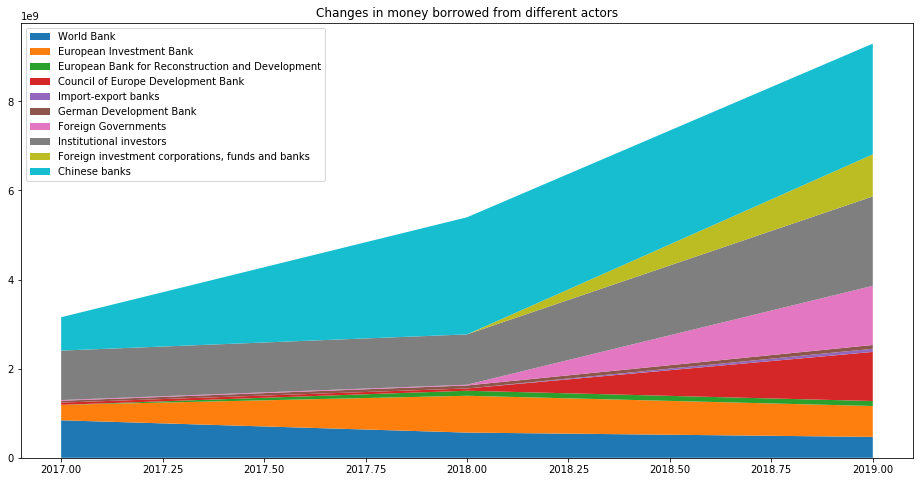

In [19]:
#here we will see also the total number of dollars borrowed by the government in this way per year
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#some retooling of the dataframe is necessary in order to prepare the visualizations
act_name_list_eng_ab=["WB", "EIB", "EBRD", "CEB", "Imp-exp banks", "KfW", "For-gov", "Inst-invest", "For-invest CFB", "China banks"]
#df_vis=({"WB", "EIB", "EBRD", "CEB", "Imp-exp banks", "KfW", "For-gov", "Inst-invest", "For-invest CFB", "China banks"

         
x=(2017,2018,2019)
y=[[841770000.0, 565943000.0, 469438000.0],
 [347097000.00000006, 826029999.9999999, 692660000.0],
 [1, 112999999.99999999, 112100000.0],
 [49950000.00000001, 50849999.99999999, 1102120000.0],
 [1, 1, 70800000.0],
 [41070000.0, 67800000.0, 84960000.0],
 [16000000.0, 16000000.0, 1327500000.0],
 [1110000000.0, 1130000000.0, 2006000000.0],
 [1, 1, 944000000.0],
 [748618888.0, 2627763335.7041254, 2484946500.0]]
#note hard coding - changing nan into 0 rather than developing a loop for changing nan-s into 0-s.

plt.figure(figsize=(16, 8))         
plt.stackplot(x,y, labels=["World Bank", "European Investment Bank", "European Bank for Reconstruction and Development", "Council of Europe Development Bank", "Import-export banks", "German Development Bank", "Foreign Governments", "Institutional investors", "Foreign investment corporations, funds and banks", "Chinese banks"])
plt.legend(loc='upper left')
plt.title("Changes in money borrowed from different actors")
plt.show()
#note: rerun this cell once again for it actually to show the image

Note: rerun the cell above once again for it actually to show the image

Here we can see not only the changing ration for three years, but also notice that the overall amount of borrowed money increases.

In [15]:
#now let's make a percent chart, to see the changing ratio between different actors

#first convert final_df into percentages
perc_df=pd.DataFrame()

perc_df["2017"]=final_df["2017"]/final_df["2017"].sum()
perc_df["2018"]=final_df["2018"]/final_df["2018"].sum()
perc_df["2019"]=final_df["2019"]/final_df["2019"].sum()
#perc_df["actors"]=year_dict_ab.keys()
#perc_df.set_index(["actors"], inplace=True)
print(perc_df) 

#now move toward overly-manual preparation of the percent-chart
#instructions listed at https://python-graph-gallery.com/255-percentage-stacked-area-chart/
#did not yield a complete chart
list_of_items=[]
for item in perc_df.index.values:
    item=[a for a in perc_df.loc[item]]
    list_of_items.append(item)

list_of_items


                    2017      2018      2019
actors                                      
WB              0.266847  0.104855  0.050507
EIB             0.110032  0.153043  0.074523
EBRD                 NaN  0.020936  0.012061
CEB             0.015834  0.009421  0.118577
Imp-exp banks        NaN       NaN  0.007617
KfW             0.013019  0.012562  0.009141
For-gov         0.005072  0.002964  0.142826
Inst-invest     0.351878  0.209361  0.215826
For-invest CFB       NaN       NaN  0.101565
China banks     0.237317  0.486858  0.267356


[[0.2668468628326745, 0.10485501033273152, 0.050506940941411255],
 [0.1100321293805111, 0.15304259295573266, 0.07452344657330238],
 [nan, 0.020936059227870406, 0.012060864436905837],
 [0.015834492555558043, 0.009421226652541682, 0.11857734088494791],
 [nan, nan, 0.007617388065414212],
 [0.013019471656792165, 0.012561635536722245, 0.009140865678497055],
 [0.005072109727506079, 0.0029643977667781107, 0.1428260262265165],
 [0.35187761234573417, 0.20936059227870407, 0.215825995186736],
 [nan, nan, 0.10156517420552283],
 [0.23731732150122398, 0.4868584852489193, 0.267355957800746]]

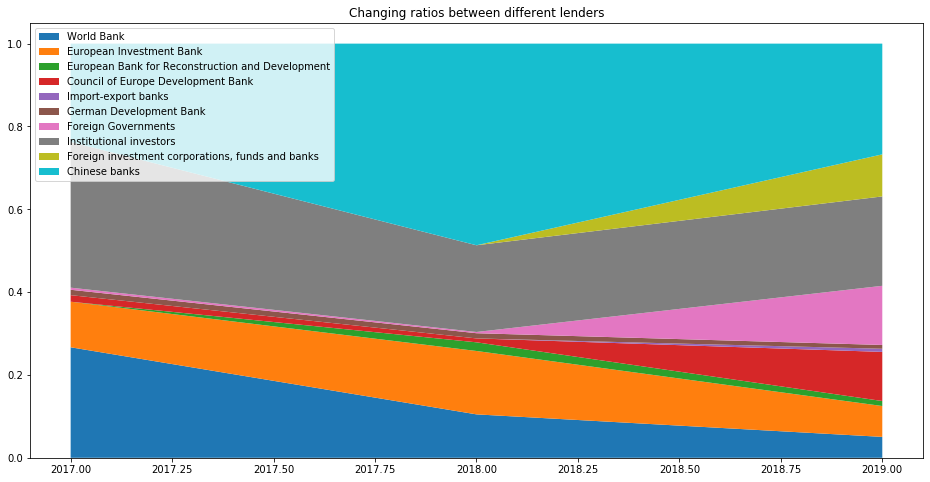

In [18]:
x=(2017,2018,2019)
y=[[0.2668468628326745, 0.10485501033273152, 0.050506940941411255],
 [0.1100321293805111, 0.15304259295573266, 0.07452344657330238],
 [0, 0.020936059227870406, 0.012060864436905837],
 [0.015834492555558043, 0.009421226652541682, 0.11857734088494791],
 [0, 0, 0.007617388065414212],
 [0.013019471656792165, 0.012561635536722245, 0.009140865678497055],
 [0.005072109727506079, 0.0029643977667781107, 0.1428260262265165],
 [0.35187761234573417, 0.20936059227870407, 0.215825995186736],
 [0, 0, 0.10156517420552283],
 [0.23731732150122398, 0.4868584852489193, 0.267355957800746]]
#note hard coding - nan-s into 0-s

plt.figure(figsize=(16, 8))       
plt.stackplot(x,y, labels=["World Bank", "European Investment Bank", "European Bank for Reconstruction and Development", "Council of Europe Development Bank", "Import-export banks", "German Development Bank", "Foreign Governments", "Institutional investors", "Foreign investment corporations, funds and banks", "Chinese banks"])
plt.legend(loc='upper left')
plt.title("Changing ratios between different lenders")
plt.show()

## Duscussion and questions for further research 

### First visualization

We can see several interesting trends based on this visualization.

The first is the growing total amount of borrowings. This calls for comparing this dataset with data on different ways debt is incurred and created by the government and the economy (eg. data on interest rates of these loans). It could mean rising trust of foreign lenders in serbian government and economy, which in turn means strengthening of the alliance between the domestic and transnational forms of rulling classes. This fits well into the thesis about emergent "stabilocracies" in Central-Eastern Europe, where growing authoritarianism is coupled with positive performance according to official and neoliberal economic indicators. If we can say that the relation between domestic and transnational forms of ruling classes are amiable, questions emerge regarding the boundaries between those two forms. Are we witnessing a "transnationalization" of domestic local ruling class, or its further division into transnationalized and domesticized factions? What does that depend on? Starting steps in that exploration would be to map more precisely how these loans are arranged and where are the power relations relevant for these loans concentrated. Another would be to bring this data into conversation with other (not necessarily extant) data on the structure and reproduction of economy - its real and financial sector, its public and private sector, etc.
For example, it is common knowledge that Germany is a very important foreign economic partner of Serbia. However, unlike another important partner - China, we do not see substantial loans from German Development Bank (KfW). We could generate more questions by further examining contrasts such as this between Germany and China, in how they exert their influence over Serbian economy and government.

The second interesting trend to note is the diversification of the lenders. From 4 main lenders in 2017 the range has expanded to at least 7 notable lenders. Here we can also note the absence of IMF (AKA the international "lender of last resort"), as well as the slowly decreasing input from the World Bank. Indeed, these numbers point that it would be reasonable to further investigate how this economic strategy (diversification of lenders) has acquired legitimacy and what was the role of transnational institutions in that.
Another interesting emergence is that of foreign investment corporations, funds and banks - showing the increasing interaction of the government with private financial actors, which should also have implications for understanding the class formation at the periphery in the age of established neoliberalism. Change in relevant actors is pointing toward new problems for neoliberal governance which might give rise to different constelation of class relations. This might also be worth further investigating in the case of increasing prominence of foreign governments as lenders.

Finally, we should comment on the importance of Chinese (state-owned) banks. After being the second largest lender in 2017, Chinese banks occupied the first position, especially in 2018. This might lead into a fruitful investigation of the relation between geoplitics and geoeconomics - or understanding the meaning of international political and economic tensions (eg. WB and IMF on one side, and Chinese banks on the other), and what is the meaning of the places of their coexistence such as Serbia.

## Second visualization

Second visualization adds clarity to the previous discussion. The issue of rising borrowed amounts is bracketed, and we can look more at the relative prominence of different actors.

We can note that World Bank's prominence decreases even more in relative terms (in comparison to other actors) than in absolute terms (the amount of money). Does that mean that it becomes also a politically less important actor, or that its importance gets rearticulated in a different way?

We can see that in 2018 China approached to being the lender of the absolute majority of money, while in 2019 we see a much more balanced picture, with no actor holding more than around 35% of the amount. Does that signify a better bargaining position of Serbian government in relation to each single actor, or greater precarity because of the rising number of potentially vulnerable relations and increasing need to balance between various lenders?

## Generated Questions and lines of research

- How does this way of debt creation relate to other ways of debt creation?
- How do these flows of money articulate with domestic and transnational ruling class formation?
    - What cleavages emerge on the level of domestic ruling class?
- What is the instituional architecture behind these loans?
- What do these flows mean for different "foreign influence" - comparing Germany and China in Serbia.
- Exploring the role of transnational financial instutions in legitimacy-making of stabilocracy regimes.
- What were the problems facing neoliberal governance in 2017 - leading to 4 lenders, and in 2019 - leading to seven?
- Exploring the relationship between geopolitics and geoeconomics.
    - exploring the spaces of coexistence of different forms of geoeconomic and geopolitical influence.
- Is the influence of World Bank waning or getting rearticulated?
- How does the increased number of relatively equal lending instances (actors) translate into bargaining power of the Serbian government, or more broadly, what does it mean for the power relations in which the government is implicated?

## Unanswered questions

These tables could be parsed in other ways as well. They often state not only the amount of money, but for what projects they have been lent. Parsing the document for that information and charting it in an accessible way could yield further and more precise insights into the dynamics, as well as interesting patterns which might lead to theoretically fruitful questions.

It is important to note that for institutional investors and foreign investment corporations, funds, and banks, these tables do not contain more specific information. Reason is that the loans by these actors consist of bonds issued by the government, and I was unable to find datasets on the circulation of those bonds. This issue should be approached in some other way.

##  Concluding remarks - Issues in generating data/politics of data

This project has, as a side effect, shown the challenges when working with different languages - English language has only traces of case system of noun and pronoun declension, unlike serbo-croatian.

Not having to deal with the problem of same word with different cases enables english development of a certain code. 
If the case was that I was developing a code in serbo-croatian, 2 ideas of different ways of coding come to mind: one idea is that inputing would present a more prominent practice as a step toward faster processing of cased nouns into the adequate form for representation. Other idea would be a development of a package which would be able to recognize and translate different cases. The case endings also change according to gender, number, and phonetics, so those are all additional challenges.

Seeing how cumbersome it is to parse through government documents (which were not intended for, yet deserve parsing), a conclusion might emerge that the way code operates and is structured accelerates power relations embedded in certain data. How data is created, what data is about, and how data are organized are not neutral issues. Some data are closer to usage in coding than some other, and some are even produced with coding in mind, while some information were more or less on purpose not intended for coding. Particular decision-making processes stand behind gathering and collecting data in a way which makes data more or less easy for coding. In explorating the manifestations of this problem lies potential for articulation of political demands for a more equitable or progressive knowledge production, generation, and dissemination.   